In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from fastdot import *

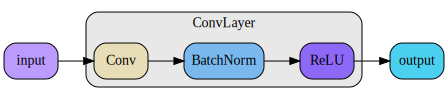

In [3]:
cl = seq_cluster(['Conv', 'BatchNorm', 'ReLU'], 'ConvLayer')
conv = cl.get_nodes()[0]
conv.set_tooltip('kernel_size=3, padding=1, bias=False, init=kaiming_uniform_')

inp = Node('input')
outp = Node('output')

g = graph_items(inp, cl, outp)
g.add_items(inp.connect(conv), cl.get_nodes()[-1].connect(outp))
g

In [4]:
def add_input_output(c, inp_tooltip='', outp_tooltip=''):
    inp = Node('input', tooltip=inp_tooltip)
    outp = Node('output', tooltip=outp_tooltip)
    g = graph_items(inp, c, outp)
    g.add_items(inp.connect(c.get_nodes()[0]), c.get_nodes()[-1].connect(outp))    
    return g

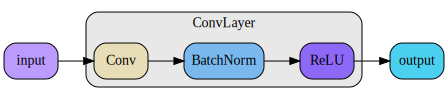

In [5]:
cl = seq_cluster(['Conv', 'BatchNorm', 'ReLU'], 'ConvLayer')
cl.get_nodes()[0].set_tooltip('kernel_size=3x3, padding=1, bias=False, init=kaiming_uniform_')

add_input_output(cl)

In [6]:
widen = 1
expansion = 4
layers = [3, 4,  6, 3]
block_szs = [int(o*widen) for o in [64,128,256,512] + [256]*(len(layers)-4)]
block_szs = [64//expansion] + block_szs
block_szs

[16, 64, 128, 256, 512]

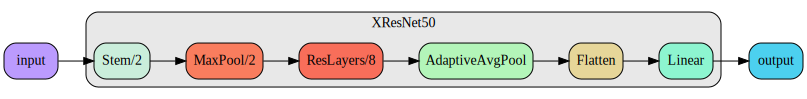

In [7]:
xrn = seq_cluster(['Stem/2', 'MaxPool/2', 'ResLayers/8', 'AdaptiveAvgPool', 'Flatten', 'Linear'], 'XResNet50')
xrn.get_nodes()[-1].set_tooltip(f'channel={block_szs[-1]*expansion}')
add_input_output(xrn, 'channel=3, resolution=224', 'channel=1000')

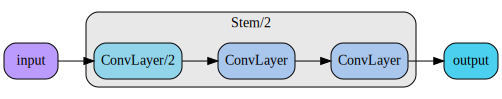

In [8]:
stem = seq_cluster(['ConvLayer/2', 'ConvLayer', 'ConvLayer'], 'Stem/2')
stem.get_nodes()[0].set_tooltip('channel=32, stride=2')
stem.get_nodes()[1].set_tooltip('channel=32')
stem.get_nodes()[2].set_tooltip('channel=64')

add_input_output(stem, 'channel=3, resolution=224', 'channel=64, resolution=112')

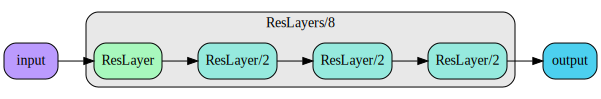

In [9]:
rls = seq_cluster(['ResLayer', 'ResLayer/2', 'ResLayer/2', 'ResLayer/2'], 'ResLayers/8')
rls.get_nodes()[0].set_tooltip(f'channel={block_szs[1] * expansion}, blocks={layers[0]}')
rls.get_nodes()[1].set_tooltip(f'channel={block_szs[2] * expansion}, blocks={layers[1]}, resolution=28')
rls.get_nodes()[2].set_tooltip(f'channel={block_szs[3] * expansion}, blocks={layers[2]}, resolution=14')
rls.get_nodes()[3].set_tooltip(f'channel={block_szs[4] * expansion}, blocks={layers[3]}, resolution=7')
add_input_output(rls, 'channel=64, resolution=56', 'channel=2048, resolution=7')

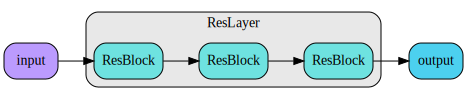

In [10]:
rl = seq_cluster(['ResBlock', 'ResBlock', 'ResBlock'], 'ResLayer')
add_input_output(rl, 'channel=64, resolution=56', 'channel=256, resolution=56')

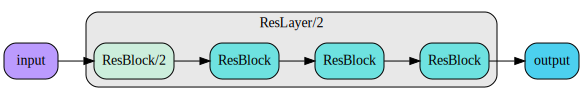

In [11]:
rl = seq_cluster(['ResBlock/2', 'ResBlock', 'ResBlock', 'ResBlock'], 'ResLayer/2')
add_input_output(rl, 'channel=256, resolution=56', 'channel=512, resolution=28')

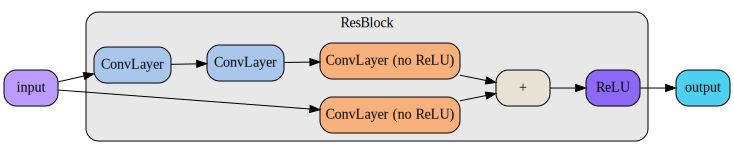

In [14]:
rb = seq_cluster(['ConvLayer', 'ConvLayer', 'ConvLayer (no ReLU)'], 'ResBlock')
nodes = rb.get_nodes()
nodes[0].set_tooltip('kernel_size=1x1, channel=64')
nodes[1].set_tooltip('kernel_size=3x3, channel=64')
nodes[2].set_tooltip('kernel_size=1x1, channel=256, BN weight initialized to 0')
id_conv, add, relu = rb.add_items('ConvLayer (no ReLU)', '+', 'ReLU')
rb.add_items(id_conv.connect(add), nodes[2].connect(add), add.connect(relu))
g = add_input_output(rb, 'channel=64, resolution=56', 'channel=256, resolution=28')
g.add_items(g.get_nodes()[0].connect(id_conv))
g

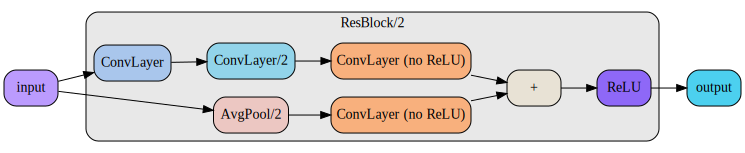

In [13]:
rb = seq_cluster(['ConvLayer', 'ConvLayer/2', 'ConvLayer (no ReLU)'], 'ResBlock/2')
nodes = rb.get_nodes()
nodes[0].set_tooltip('kernel_size=1x1, channel=128')
nodes[1].set_tooltip('kernel_size=3x3, channel=128')
nodes[2].set_tooltip('kernel_size=1x1, channel=512, BN weight initialized to 0')
pool, id_conv, add, relu = rb.add_items('AvgPool/2', 'ConvLayer (no ReLU)', '+', 'ReLU')
rb.add_items(pool.connect(id_conv), id_conv.connect(add), nodes[2].connect(add), add.connect(relu))
g = add_input_output(rb, 'channel=256, resolution=28', 'channel=512, resolution=14')
g.add_items(g.get_nodes()[0].connect(pool))
g